In [1]:
from __future__ import division, print_function


#Verify we are in the lesson1 directory
%pwd
INIT_DATA=False
nbs_dir="."

In [2]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"]=""  # force cpu usage for tensorflow
#os.chdir(nbs_dir)
current_dir = os.getcwd()
print('current dir:',current_dir)
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data/seedlings'
categories = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 
              'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 
              'Sugar beet']

current dir: /home/aziz/deeplearning_keras2/nbs


In [3]:
#Allow relative imports to directories above lesson1/
sys.path.insert(1, os.path.join(sys.path[0], '..'))

#import modules
from utils import *
from vgg16 import Vgg16

#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

Using Theano backend.


In [4]:
#Create directories
if INIT_DATA:
    %cd $DATA_HOME_DIR
    %mkdir valid
    %mkdir results
    for category in categories:
        %mkdir -p "sample/train/$category"
        %mkdir -p "sample/valid/$category"
        %mkdir -p "valid/$category"
    %mkdir -p sample/test
    %mkdir -p sample/results
    %mkdir -p test/unknown

In [5]:
if INIT_DATA:
    %cd $DATA_HOME_DIR/train

In [6]:
if INIT_DATA:
    print(os.getcwd())
    for category in categories:
        g = glob(os.path.join(category, '*.png'))
        print("found {} pictures for {}".format(len(g), category))
        shuf = np.random.permutation(g)
        if g:
            for i in range(100):
                pic_id = os.path.basename(shuf[i])
                new_path = os.path.join(DATA_HOME_DIR, 'valid', category, pic_id)
                #print("new path:", new_path)
                os.rename(shuf[i], new_path)

In [7]:
from shutil import copyfile

In [8]:
if INIT_DATA:
    print(os.getcwd())
    for category in categories:
        g = glob(os.path.join(category, '*.png'))
        print("found {} pictures for {}".format(len(g), category))
        shuf = np.random.permutation(g)
        if g:
            for i in range(16):
                pic_id = os.path.basename(shuf[i])
                new_path = os.path.join(DATA_HOME_DIR, 'sample', 'train', category, pic_id)
                #print("new path:", new_path)
                copyfile(shuf[i], new_path)

In [9]:
if INIT_DATA:
    %cd $DATA_HOME_DIR/valid

In [10]:
if INIT_DATA:
    print(os.getcwd())
    for category in categories:
        g = glob(os.path.join(category, '*.png'))
        print("found {} pictures for {}".format(len(g), category))
        shuf = np.random.permutation(g)
        if g:
            for i in range(4):
                pic_id = os.path.basename(shuf[i])
                new_path = os.path.join(DATA_HOME_DIR, 'sample', 'valid', category, pic_id)
                #print("new path:", new_path)
                copyfile(shuf[i], new_path)

In [11]:
# Create single 'unknown' class for test set
if INIT_DATA:
    %cd $DATA_HOME_DIR/test
    %mv *.png unknown/

## Finetuning and Training

In [12]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + '/sample/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path=DATA_HOME_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

/home/aziz/deeplearning_keras2/nbs/data/seedlings


In [13]:
#import Vgg16 helper class
vgg = Vgg16()

In [14]:
#Set constants. You can experiment with no_of_epochs to improve the model
#batch_size=64
batch_size=4
no_of_epochs=6

In [15]:
#Finetune the model
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

#Not sure if we set this for all fits
vgg.model.optimizer.lr = 0.01

Found 192 images belonging to 12 classes.
Found 48 images belonging to 12 classes.


In [16]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print("Running epoch: %d" % epoch)
    vgg.fit(batches, val_batches, batch_size, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
print("Completed %s fit operations" % no_of_epochs)

Running epoch: 0
Epoch 1/1
48/48 [==============================] - 64s 1s/step - loss: 13.6400 - acc: 0.1094 - val_loss: 12.8725 - val_acc: 0.1667
Running epoch: 1
Epoch 1/1
48/48 [==============================] - 65s 1s/step - loss: 12.9305 - acc: 0.1615 - val_loss: 13.0960 - val_acc: 0.1875
Running epoch: 2
Epoch 1/1
48/48 [==============================] - 64s 1s/step - loss: 12.1149 - acc: 0.2240 - val_loss: 12.1345 - val_acc: 0.2083
Running epoch: 3
Epoch 1/1
48/48 [==============================] - 64s 1s/step - loss: 11.8871 - acc: 0.2344 - val_loss: 12.3832 - val_acc: 0.2292
Running epoch: 4
Epoch 1/1
48/48 [==============================] - 64s 1s/step - loss: 11.9037 - acc: 0.2500 - val_loss: 12.0909 - val_acc: 0.2500
Running epoch: 5
Epoch 1/1
48/48 [==============================] - 64s 1s/step - loss: 11.7922 - acc: 0.2552 - val_loss: 12.4245 - val_acc: 0.2292
Completed 6 fit operations


## Generate Predictions

Let's use our new model to make predictions on the test dataset

In [17]:
batches, preds = vgg.test(test_path, batch_size = batch_size*2)

Found 794 images belonging to 1 classes.


In [18]:
#For every image, vgg.test() generates two probabilities 
#based on how we've ordered the cats/dogs directories.
#It looks like column one is cats and column two is dogs
print(preds[:5])

filenames = batches.filenames
print(filenames[:5])

[[  1.0000e+00   6.2013e-15   1.4013e-45   0.0000e+00   1.4013e-45   1.4013e-45   4.2039e-45
    1.6391e-14   5.2791e-31   2.8026e-45   2.7104e-22   0.0000e+00]
 [  1.0000e+00   4.0561e-28   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00
    1.8498e-10   4.9186e-38   0.0000e+00   3.3226e-39   0.0000e+00]
 [  9.7557e-01   1.4797e-16   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00
    2.4432e-02   3.6270e-31   0.0000e+00   5.2242e-33   0.0000e+00]
 [  1.2201e-01   8.7799e-01   1.6129e-42   6.8664e-44   2.8166e-43   9.3887e-44   8.0855e-43
    1.0770e-09   5.7417e-20   1.7993e-42   5.6496e-28   1.4574e-43]
 [  2.4737e-08   1.0003e-12   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00
    1.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00]]
['unknown/0021e90e4.png', 'unknown/003d61042.png', 'unknown/007b3da8b.png', 'unknown/0086a6340.png', 'unknown/00c47e980.png']


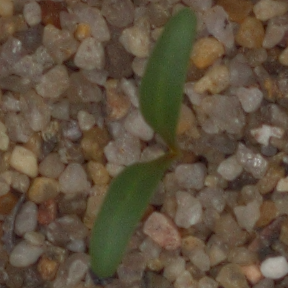

In [19]:
#You can verify the column ordering by viewing some images
from PIL import Image
Image.open(test_path + filenames[2])

In [20]:
#Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

## Validate Predictions

Keras' fit() function conveniently shows us the value of the loss function, and the accuracy, after every epoch ("epoch" refers to one full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting.

Tip: with our first model we should try to overfit before we start worrying about how to reduce over-fitting - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques shortly).
As well as looking at the overall metrics, it's also a good idea to look at examples of each of:

A few correct labels at random
A few incorrect labels at random
The most correct labels of each class (ie those with highest probability that are correct)
The most incorrect labels of each class (ie those with highest probability that are incorrect)
The most uncertain labels (ie those with probability closest to 0.5).

Let's see what we can learn from these examples. (In general, this is a particularly useful technique for debugging problems in the model. However, since this model is so simple, there may not be too much to learn at this stage.)

Calculate predictions on validation set, so we can find correct and incorrect examples:

In [21]:
vgg.model.load_weights(results_path+latest_weights_filename)

In [22]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 48 images belonging to 12 classes.


In [23]:
filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1
print("expected labels:",expected_labels)
print(probs.shape)
#Round our predictions to 0/1 to generate labels
print(type(probs))
our_predictions = probs[:,0]
print(our_predictions)
our_labels = np.round(1-our_predictions)
print("our labels:",our_labels)

expected labels: [ 0  0  0  0  1  1  1  1  2  2  2  2  3  3  3  3  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  7  8
  8  8  8  9  9  9  9 10 10 10 10 11 11 11 11]
(48, 12)
<class 'numpy.ndarray'>
[  1.0000e+00   1.0000e+00   1.0000e+00   1.0000e+00   5.0279e-26   7.2815e-36   2.5483e-19
   4.2987e-20   1.0000e+00   5.1485e-08   1.2959e-21   3.7456e-17   8.4403e-10   8.4852e-14
   1.0000e+00   9.9999e-01   5.8484e-04   2.1868e-05   1.0000e+00   1.0000e+00   1.0000e+00
   2.8026e-45   1.0000e+00   9.9997e-01   1.0000e+00   1.0000e+00   1.0000e+00   1.0000e+00
   6.3997e-23   0.0000e+00   7.1508e-20   1.0089e-31   9.9987e-01   1.0000e+00   1.0000e+00
   1.0000e+00   6.6867e-07   9.9965e-01   1.4649e-08   1.3605e-04   1.9642e-09   1.7817e-01
   2.3786e-08   9.6710e-04   1.4052e-18   1.6796e-25   2.8966e-18   2.1603e-23]
our labels: [ 0.  0.  0.  0.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.  1.  0.  1.  

In [24]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

Found 8 correct labels


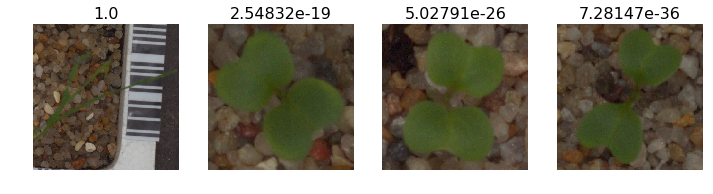

In [25]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print("Found %d correct labels" % len(correct))
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 40 incorrect labels


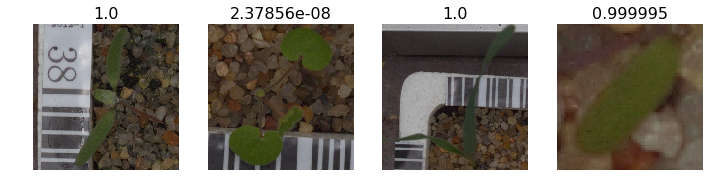

In [26]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print("Found %d incorrect labels" % len(incorrect))
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

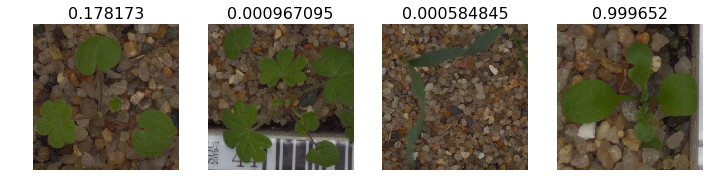

In [27]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

Perhaps the most common way to analyze the result of a classification model is to use a confusion matrix. Scikit-learn has a convenient function we can use for this purpose:

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[4 0 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0 0 0]
 [1 3 0 0 0 0 0 0 0 0 0 0]
 [2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 0 0 0 0 0 0 0 0 0 0]
 [3 1 0 0 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0 0 0]
 [1 3 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0 0 0]]


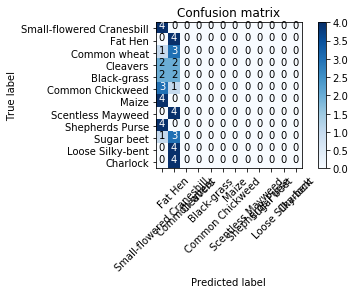

In [29]:
plot_confusion_matrix(cm, val_batches.class_indices)